In [ ]:
# Task 4 - Model Comparison
import sys
from pathlib import Path

ROOT = Path.cwd().parents[1] 
sys.path.append(str(ROOT / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score, roc_curve, auc,  roc_auc_score
from sklearn.svm import SVC
from utils import savefig
from paths import OUTPUTS

RNG = 42 #sets a fixed random seed so that splitting the dataset into training, validation, and test sets produce the same results every time the code is run

In [44]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RNG
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RNG
)

scaler = StandardScaler().fit(X_train)
X_train_s = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns=X.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

dt_best = DecisionTreeClassifier(max_depth=2, min_samples_leaf=4, random_state=RNG)
svm_lin = SVC(kernel="linear", C=0.1, random_state=RNG)
svm_rbf = SVC(kernel="rbf", gamma=0.05, random_state=RNG)

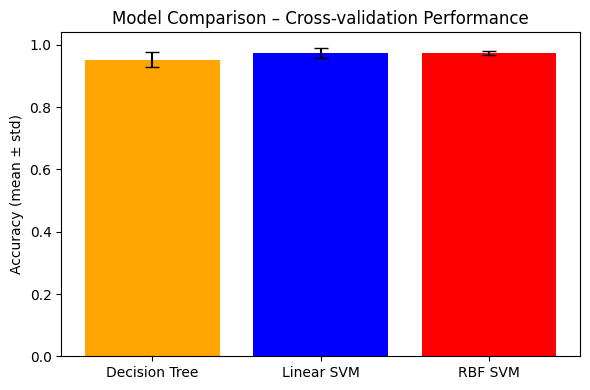

In [46]:
models = ["Decision Tree", "Linear SVM", "RBF SVM"]
acc_mean = [0.953, 0.9736, 0.9736]  # your mean accuracies
acc_std = [0.025, 0.0172, 0.0058]   # corresponding std

plt.figure(figsize=(6,4))
plt.bar(models, acc_mean, yerr=acc_std, capsize=5, color=["orange", "blue", "red"])
plt.ylabel("Accuracy (mean ± std)")
plt.title("Model Comparison – Cross-validation Performance")
plt.tight_layout()
savefig("model_comparison.png")
plt.show()


All three models achieved high cross-validation accuracy, but the SVM models—both Linear and RBF—generalize slightly better than the Decision Tree. The SVMs show higher mean accuracy and smaller standard deviation, indicating more consistent performance across folds and better robustness to unseen data. Among them, the RBF SVM has the most stable results, suggesting that it generalizes best overall, while the Linear SVM remains a simpler yet nearly equally effective alternative.

In [24]:
# --- Fit and evaluate on validation set ---
dt_best.fit(X_train, y_train)
svm_lin.fit(X_train_s, y_train)
svm_rbf.fit(X_train_s, y_train)

y_pred_dt = dt_best.predict(X_val)
y_pred_svm_lin = svm_lin.predict(X_val_s)
y_pred_svm_rbf = svm_rbf.predict(X_val_s)

# F1 (β=1) og F2 (weighs recall more)
f1_dt = fbeta_score(y_val, y_pred_dt, beta=1)
f2_dt = fbeta_score(y_val, y_pred_dt, beta=2)
f1_svm_lin = fbeta_score(y_val, y_pred_svm_lin, beta=1)
f2_svm_lin = fbeta_score(y_val, y_pred_svm_lin, beta=2)
f1_svm_rbf = fbeta_score(y_val, y_pred_svm_rbf, beta=1)
f2_svm_rbf = fbeta_score(y_val, y_pred_svm_rbf, beta=2)

print(f"Decision Tree – F1: {f1_dt:.3f}, F2: {f2_dt:.3f}")
print(f"Linear SVM – F1: {f1_svm_lin:.3f}, F2: {f2_svm_lin:.3f}")
print(f"RBF SVM – F1: {f1_svm_rbf:.3f}, F2: {f2_svm_rbf:.3f}")


Decision Tree – F1: 0.966, F2: 0.978
Linear SVM – F1: 0.973, F2: 0.981
RBF SVM – F1: 0.979, F2: 0.983


The Decision Tree, Linear SVM, and RBF SVM all achieved high performance on the breast cancer dataset, with F1 and F2 scores between 0.97 and 0.98. While the RBF SVM showed the highest accuracy (F1 = 0.979, F2 = 0.983), it is a black-box model with limited interpretability, making it less suitable for clinical decision support. The Decision Tree, on the other hand, provides transparent, rule-based decisions that can be easily interpreted and validated by medical professionals, which is essential in healthcare applications. Although it has slightly lower accuracy (F1 = 0.966, F2 = 0.978), its interpretability makes it the most appropriate choice for a medical decision-support system, where explainability and trust are as important as predictive performance.

Decision Tree best: {'max_depth': 2, 'min_samples_leaf': 4} Val acc=0.9561, AUC=0.9451
Linear SVM best: {'C': 0.1} Val acc=0.9649, AUC=0.9990
RBF SVM best: {'C': 10, 'gamma': 0.01} Val acc=0.9912, AUC=0.9997


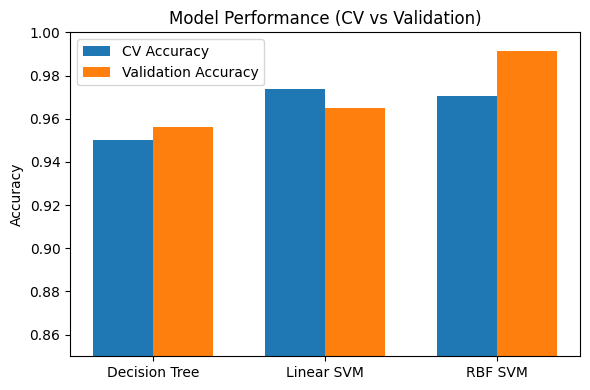

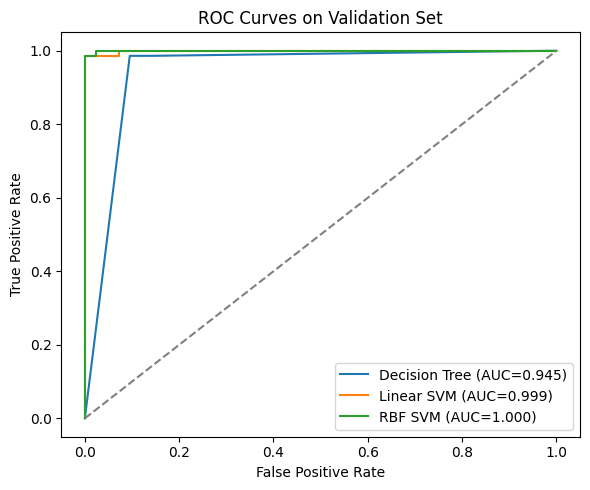

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# === Decision Tree GridSearch ===
dt_params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4, 6, 8, 10]
}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RNG),
    dt_params, cv=cv, scoring="accuracy", n_jobs=-1
).fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
dt_val_pred = dt_best.predict(X_val)
dt_val_acc = accuracy_score(y_val, dt_val_pred)
dt_val_auc = auc(*roc_curve(y_val, dt_best.predict_proba(X_val)[:,1])[:2])
print("Decision Tree best:", dt_grid.best_params_,
      f"Val acc={dt_val_acc:.4f}, AUC={dt_val_auc:.4f}")


# === Linear SVM GridSearch ===
svm_lin_params = {"C": [0.01, 0.1, 1, 10, 100]}
svm_lin_grid = GridSearchCV(
    SVC(kernel="linear", random_state=RNG),
    svm_lin_params, cv=cv, scoring="accuracy", n_jobs=-1
).fit(X_train_s, y_train)
svm_lin_best = svm_lin_grid.best_estimator_
lin_val_pred = svm_lin_best.predict(X_val_s)
lin_val_acc = accuracy_score(y_val, lin_val_pred)
fpr_lin, tpr_lin, _ = roc_curve(y_val, svm_lin_best.decision_function(X_val_s))
lin_val_auc = auc(fpr_lin, tpr_lin)
print("Linear SVM best:", svm_lin_grid.best_params_,
      f"Val acc={lin_val_acc:.4f}, AUC={lin_val_auc:.4f}")


# === RBF SVM GridSearch ===
svm_rbf_params = {
    "C": [0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1]
}
svm_rbf_grid = GridSearchCV(
    SVC(kernel="rbf", random_state=RNG),
    svm_rbf_params, cv=cv, scoring="accuracy", n_jobs=-1
).fit(X_train_s, y_train)
svm_rbf_best = svm_rbf_grid.best_estimator_
rbf_val_pred = svm_rbf_best.predict(X_val_s)
rbf_val_acc = accuracy_score(y_val, rbf_val_pred)
fpr_rbf, tpr_rbf, _ = roc_curve(y_val, svm_rbf_best.decision_function(X_val_s))
rbf_val_auc = auc(fpr_rbf, tpr_rbf)
print("RBF SVM best:", svm_rbf_grid.best_params_,
      f"Val acc={rbf_val_acc:.4f}, AUC={rbf_val_auc:.4f}")


# === Plot 1: CV vs Validation Accuracy ===
models = ["Decision Tree", "Linear SVM", "RBF SVM"]
cv_scores = [dt_grid.best_score_, svm_lin_grid.best_score_, svm_rbf_grid.best_score_]
val_scores = [dt_val_acc,        lin_val_acc,               rbf_val_acc]

x = np.arange(len(models))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, cv_scores,  width=w, label="CV Accuracy")
plt.bar(x + w/2, val_scores, width=w, label="Validation Accuracy")
plt.xticks(x, models, rotation=0)
plt.ylabel("Accuracy")
plt.title("Model Performance (CV vs Validation)")
plt.ylim(0.85, 1.00)
plt.legend()
plt.tight_layout()
savefig("cv_vs_validation_accuracy.png")
plt.show()



# === Plot 2: ROC Curves on Validation Set (with AUC) ===
plt.figure(figsize=(6,5))

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_val, dt_best.predict_proba(X_val)[:,1])
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={dt_val_auc:.3f})")

# Linear SVM
plt.plot(fpr_lin, tpr_lin, label=f"Linear SVM (AUC={lin_val_auc:.3f})")

# RBF SVM
plt.plot(fpr_rbf, tpr_rbf, label=f"RBF SVM (AUC={rbf_val_auc:.3f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Validation Set")
plt.legend()
plt.tight_layout()
savefig("roc_curves_on_validation_set.png")
plt.show()


The best settings for Decision tree are max_depth': 2, 'min_samples_leaf': 4.

The best settings for Linear SVM are 'C': 0.1.

The best settings for RBF SVM are 'C': 10, 'gamma': 0.01.

Decision Tree – Test Accuracy: 0.9123, AUC: 0.8978
Linear SVM – Test Accuracy: 0.9649, AUC: 0.9912
RBF SVM – Test Accuracy: 0.9474, AUC: 0.9961


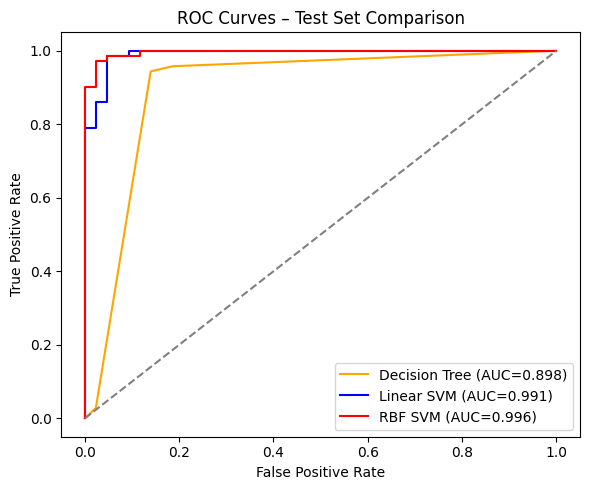

In [47]:
dt_final = dt_grid.best_estimator_.fit(X_train, y_train)
svm_lin_final = svm_lin_grid.best_estimator_.fit(X_train_s, y_train)
svm_rbf_final = svm_rbf_grid.best_estimator_.fit(X_train_s, y_train)

# --- Predict on test set ---
y_pred_dt = dt_final.predict(X_test)
y_pred_svm_lin = svm_lin_final.predict(X_test_s)
y_pred_svm_rbf = svm_rbf_final.predict(X_test_s)

acc_dt = accuracy_score(y_test, y_pred_dt)
acc_svm_lin = accuracy_score(y_test, y_pred_svm_lin)
acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)

auc_dt = roc_auc_score(y_test, dt_final.predict_proba(X_test)[:, 1])
auc_svm_lin = roc_auc_score(y_test, svm_lin_final.decision_function(X_test_s))
auc_svm_rbf = roc_auc_score(y_test, svm_rbf_final.decision_function(X_test_s))

print(f"Decision Tree – Test Accuracy: {acc_dt:.4f}, AUC: {auc_dt:.4f}")
print(f"Linear SVM – Test Accuracy: {acc_svm_lin:.4f}, AUC: {auc_svm_lin:.4f}")
print(f"RBF SVM – Test Accuracy: {acc_svm_rbf:.4f}, AUC: {auc_svm_rbf:.4f}")

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_final.predict_proba(X_test)[:, 1])
fpr_lin, tpr_lin, _ = roc_curve(y_test, svm_lin_final.decision_function(X_test_s))
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, svm_rbf_final.decision_function(X_test_s))

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})", color="orange")
plt.plot(fpr_lin, tpr_lin, label=f"Linear SVM (AUC={auc_svm_lin:.3f})", color="blue")
plt.plot(fpr_rbf, tpr_rbf, label=f"RBF SVM (AUC={auc_svm_rbf:.3f})", color="red")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Test Set Comparison")
plt.legend()
plt.tight_layout()
savefig("roc_curves_test_set_comparison.png")
plt.show()


Both SVM models outperform the Decision Tree on the test set.
The Linear SVM achieves the highest accuracy (0.965) and a strong AUC (0.991), indicating that it makes the fewest classification errors overall.
The RBF SVM achieves a slightly lower accuracy (0.947) but the highest AUC (0.996), meaning it ranks malignant cases more reliably across varying thresholds.

In medical applications, where identifying malignant cases correctly is critical, AUC is often more important than raw accuracy.
Therefore, while the Linear SVM is slightly more accurate, the RBF SVM offers better discrimination and robustness, making it the preferred model in a medical decision-support setting.

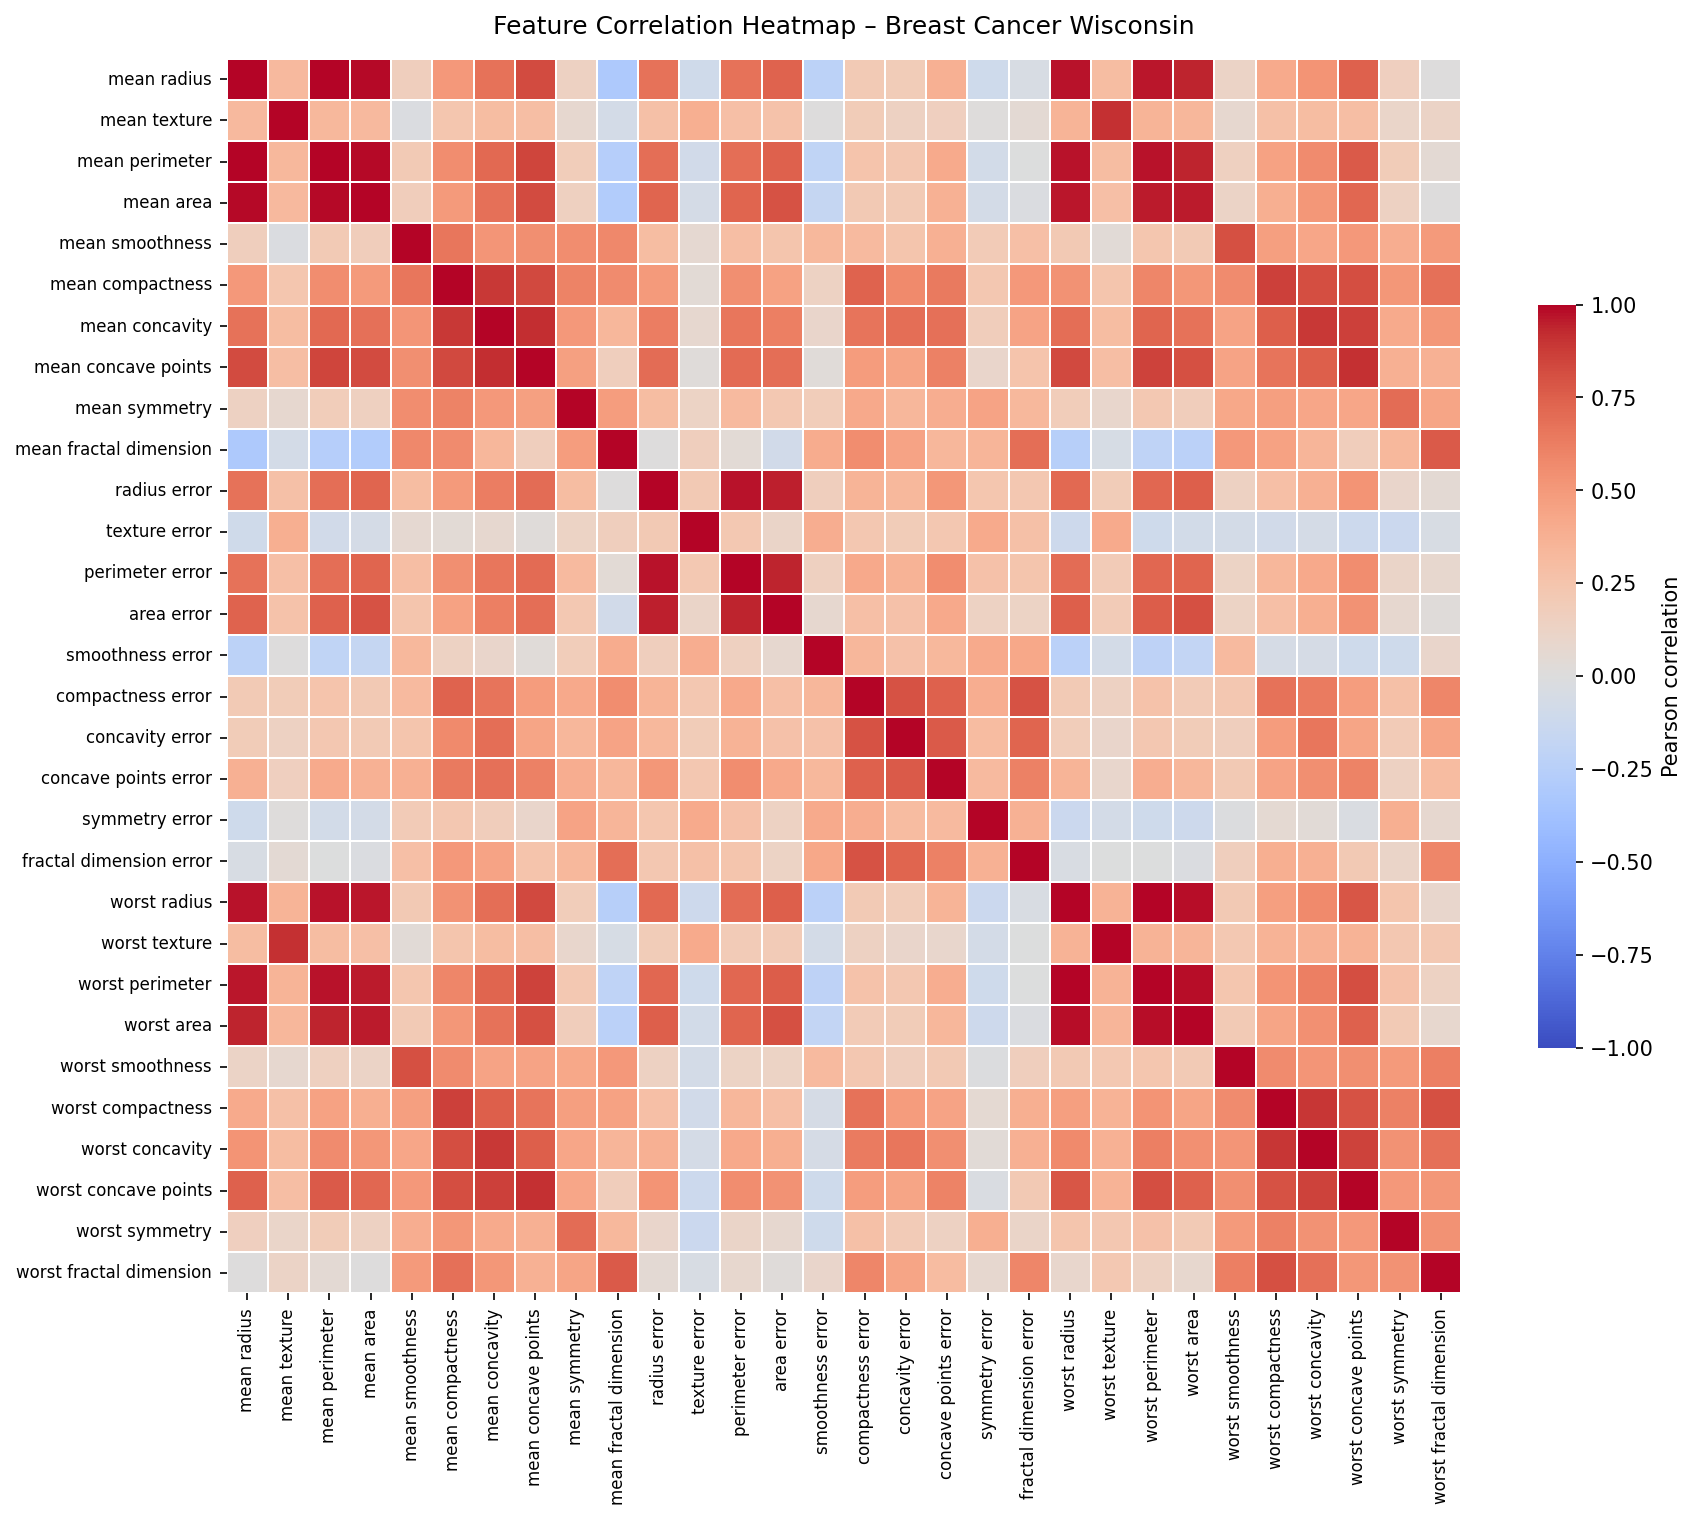

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Correlation matrix ---
corr = X.corr()

plt.figure(figsize=(12, 10), dpi=150)
ax = sns.heatmap(
    corr, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True,
    cbar_kws={"shrink": .6, "label": "Pearson correlation"},
    xticklabels=True, yticklabels=True, linewidths=0.2, linecolor="white"
)

ax.set_title("Feature Correlation Heatmap – Breast Cancer Wisconsin", pad=12)
ax.tick_params(axis="x", rotation=90, labelsize=8)
ax.tick_params(axis="y", rotation=0,  labelsize=8)
plt.tight_layout()
savefig("feature_correlation_heatmap.png")
plt.show()


The Breast Cancer Wisconsin dataset contains 30 continuous features that are often correlated and not linearly separable, meaning the two classes (benign and malignant) cannot be divided cleanly by a straight line or hyperplane. A linear SVM assumes that the data can be separated with a linear boundary, so it struggles when the relationship between features and classes is non-linear or when the data clusters overlap in complex ways.

The RBF (Radial Basis Function) kernel, on the other hand, projects the data into a higher-dimensional feature space, where it becomes easier to separate using a curved, non-linear decision boundary. This allows the RBF SVM to capture subtle and complex relationships between correlated features that a linear SVM would miss.

In terms of geometry, the linear SVM draws a single flat plane through the original feature space, while the RBF kernel effectively bends and warps the space, allowing the model to fit curved and flexible boundaries around the malignant and benign clusters — leading to better classification performance on this dataset.